In [11]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [2]:
colors = list()
for _ in range(11):
    colors.append([int(j) for j in np.random.randint(0, 255, 3)])

In [3]:
class Store():
    def __init__(self,pos,size,text):
        self.pos=pos
        self.size=size
        self.text=text

def draw(img, storedVar):

    for button in storedVar:
        x, y = button.pos
        w, h = button.size
        cv2.rectangle(img, (x - w, y - h), (x + w, y + h), (64, 64, 64), thickness=2)
    return img

In [4]:
StoredVar = []

StoredVar.append(Store([400, 250],[35, 35],"2"))
StoredVar.append(Store([880, 250],[35, 35],"3"))
StoredVar.append(Store([640, 310],[100, 30],"4"))
StoredVar.append(Store([490, 430],[35, 70],"5"))
StoredVar.append(Store([640, 430],[40, 40],"6"))
StoredVar.append(Store([790, 430],[35, 70],"7"))
StoredVar.append(Store([640, 550],[100, 30],"8"))
StoredVar.append(Store([400, 600],[35, 35],"9"))
StoredVar.append(Store([880, 600],[35, 35],"10"))

In [5]:
img = np.full((960, 1280, 3), 255, np.uint8)
img = draw(img, StoredVar)
img2 = np.zeros_like(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, th = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

cnt, labels, stats, centroids = cv2.connectedComponentsWithStats(th)

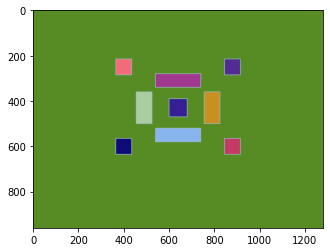

In [6]:
for i in range(cnt):
    img2[labels==i] = colors[i]
    # img2[labels==i] = colors[i]

plt.imshow(img2)

In [107]:
data = pd.DataFrame(columns=['x','y','label'])

In [108]:
for _ in range(30000):
    x = np.random.randint(0, 1280)
    y = np.random.randint(0, 960)
    label = labels[y][x]
    temp = pd.DataFrame({'x':[x], 'y':[y], 'label':[label]})

    data = data.append(temp, ignore_index=True)

In [109]:
data['x'] = data['x']/1279
data['y'] = data['y']/959
data.head()

,x,y,label
0,0.215794,0.713243,1
1,0.289289,0.19708,1
2,0.127443,0.996872,1
3,0.985145,0.855057,1
4,0.924941,0.676747,1


In [110]:
X_data = data.drop(columns=['label']).values
X_data = X_data/X_data.max()

y_data = data['label'].values

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float64)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float64)
# X_test = tf.convert_to_tensor(X_test, dtype=tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float64)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float64)
# y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)

In [112]:
model = Sequential([
    InputLayer(input_shape=(2,)),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(11, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                715       
Total params: 17,483
Trainable params: 17,483
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [114]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='auto')

In [115]:
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128, validation_batch_size=128, epochs=300, callbacks=[early_stopping])

Epoch 1/300
188/188 [==============================] - 1s 3ms/step - loss: 0.5957 - accuracy: 0.9328 - val_loss: 0.3632 - val_accuracy: 0.9328
Epoch 2/300
188/188 [==============================] - 0s 2ms/step - loss: 0.3068 - accuracy: 0.9411 - val_loss: 0.3305 - val_accuracy: 0.9328
Epoch 3/300
188/188 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.9411 - val_loss: 0.3165 - val_accuracy: 0.9328
Epoch 4/300
188/188 [==============================] - 0s 2ms/step - loss: 0.2771 - accuracy: 0.9411 - val_loss: 0.2953 - val_accuracy: 0.9328
Epoch 5/300
188/188 [==============================] - 0s 2ms/step - loss: 0.2553 - accuracy: 0.9411 - val_loss: 0.2739 - val_accuracy: 0.9328
Epoch 6/300
188/188 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.9411 - val_loss: 0.2425 - val_accuracy: 0.9328
Epoch 7/300
188/188 [==============================] - 0s 1ms/step - loss: 0.2127 - accuracy: 0.9411 - val_loss: 0.2183 - val_accuracy: 0.9328

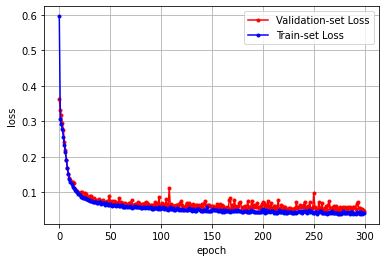

In [116]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

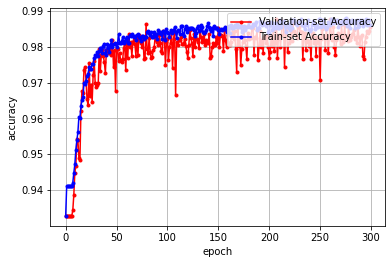

In [117]:
y_vacc = hist.history['val_accuracy']
y_acc = hist.history['accuracy']

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, marker='.', c='red', label="Validation-set Accuracy")
plt.plot(x_len, y_acc, marker='.', c='blue', label="Train-set Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [118]:
test_data = pd.DataFrame(columns=['x','y','label'])
for _ in range(10000):
    x = np.random.randint(0, 1280)
    y = np.random.randint(0, 960)
    label = labels[y][x]
    temp = pd.DataFrame({'x':[x], 'y':[y], 'label':[label]})

    test_data = test_data.append(temp, ignore_index=True)

In [119]:
test_data['x'] = test_data['x']/1279
test_data['y'] = test_data['y']/959
X_test = test_data.drop(columns=['label']).values
y_test = test_data['label'].values
X_test = tf.convert_to_tensor(X_test, dtype=tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float64)

In [120]:
model.evaluate(X_test, y_test, batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 0.0460 - accuracy: 0.9875


[0.04597961902618408, 0.987500011920929]

In [121]:
model.save("keyboard-small")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: keyboard-small\assets


In [23]:
test_data = pd.DataFrame(columns=['x','y'])
for x in range(1280):
    for y in range(960):
        temp = pd.DataFrame({'x':[x], 'y':[y]})

        test_data = test_data.append(temp, ignore_index=True)

In [32]:
test_data.to_hdf('1280x960.h5', key='df', mode='w')

c:\Users\KYH\.conda\envs\tensor\lib\site-packages\pandas\core\generic.py:2718: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Index(['x', 'y'], dtype='object')]

  encoding=encoding,


In [24]:
test_data['x'] = test_data['x']/1279
test_data['y'] = test_data['y']/959
test_input = tf.convert_to_tensor(test_data, dtype=tf.float64)
pred = model.predict_classes(test_input)
pred = tf.reshape(pred, [1280, 960]).numpy()

In [27]:
test = np.full((960, 1280, 3), 255, np.uint8)
for y in range(960):
    print(y)
    for x in range(1280):
        test[y][x] = colors[pred[x][y]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

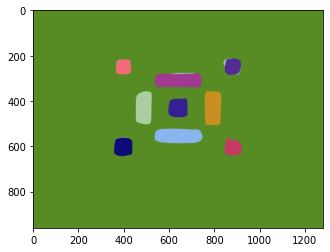

In [30]:
plt.imshow(test)

In [12]:
model = load_model('keyboard-small')

In [13]:
test_data2 = pd.DataFrame(columns=['x','y'])
for x in range(200):
    for y in range(200):
        temp = pd.DataFrame({'x':[x], 'y':[y]})

        test_data2 = test_data2.append(temp, ignore_index=True)

In [14]:
test_data2['x'] = test_data2['x']/200
test_data2['y'] = test_data2['y']/200
test_input2 = tf.convert_to_tensor(test_data2, dtype=tf.float64)
pred2 = model.predict_classes(test_input2)
pred2 = tf.reshape(pred2, [200, 200]).numpy()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [15]:
test2 = np.full((200, 200, 3), 255, np.uint8)
for y in range(200):
    print(y)
    for x in range(200):
        test2[y][x] = colors[pred2[x][y]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


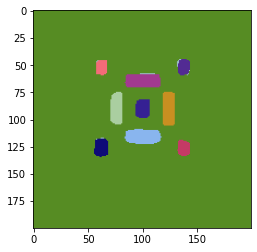

In [16]:
plt.imshow(test2)

In [17]:
test_data3 = pd.DataFrame(columns=['x','y'])
for x in range(800):
    for y in range(600):
        temp = pd.DataFrame({'x':[x], 'y':[y]})

        test_data3 = test_data3.append(temp, ignore_index=True)

In [18]:
test_data3['x'] = test_data3['x']/800
test_data3['y'] = test_data3['y']/600
test_input3 = tf.convert_to_tensor(test_data3, dtype=tf.float64)

In [19]:
pred3 = model.predict_classes(test_input3)

In [20]:
pred3 = tf.reshape(pred3, [800, 600]).numpy()

In [21]:
test3 = np.full((600, 800, 3), 255, np.uint8)
for y in range(600):
    print(y)
    for x in range(800):
        test3[y][x] = colors[pred3[x][y]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

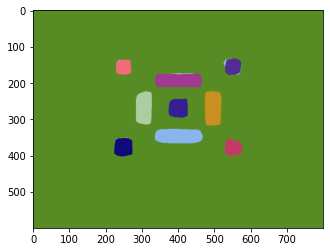

In [22]:
plt.imshow(test3)